# CNN pour classification binaire

In [16]:
import pandas as pd
from test import convertCatToNum, drop_rows_with_missing, normalize, encode_player_names, split_data
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# on import toutes les données

df_atp = pd.read_csv('all_matches_ATP.csv')

In [17]:
df_atp.columns

Index(['Court', 'Surface', 'Round', 'Player1_name', 'Player2_name',
       'Player1_rank', 'Player2_rank', 'Comment', 'Series', 'y'],
      dtype='object')

In [18]:

cat_cols = ['Court','Surface','Round','Comment']

num_cols = ["Player1_rank","Player2_rank", "Series",]


In [19]:
df_processed = convertCatToNum(df=df_atp,cat_cols=cat_cols)
df = drop_rows_with_missing(df_processed,columns=["y","Series"])
df_atp = normalize(df,num_cols)
df_final = encode_player_names(df=df_atp)

X_train, X_test, y_train, y_test = split_data(df_final, target_column='y', test_size=0.2, random_state=42)


 ===     Replace categorial variable     ===
 ===   Convert categorical to numerical  ===
 ===         drop missing values         ===
 ===            Normalize data           ===
=== Encoding player names ===
Encoding completed.
=== Splitting data into train and test sets ===
Data split completed.


In [20]:
X_train.shape

(33448, 26)

In [21]:
X_test = X_test.values.reshape((X_test.shape[0], 26, 1))
X_train = X_train.values.reshape((X_train.shape[0], 26, 1))

In [22]:
nbr_test_valid = int(len(X_test)/2)

X_valid = X_test[:nbr_test_valid]
X_test = X_test[nbr_test_valid:]

y_valid = y_test[:nbr_test_valid]
y_test = y_test[nbr_test_valid:]

In [23]:
print('X_train :',X_train.shape)
print('y_train :',y_train.shape)
print('X_test :',X_test.shape)
print('y_test :',y_test.shape)
print('X_valid :',X_valid.shape)
print('y_valid :',y_valid.shape)

X_train : (33448, 26, 1)
y_train : (33448,)
X_test : (4182, 26, 1)
y_test : (4182,)
X_valid : (4181, 26, 1)
y_valid : (4181,)


# CNN binaire

In [24]:
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers, models
import tensorflow as tf
import time

In [25]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    model_cnn_bin = models.Sequential([
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(26, 1)),
        layers.BatchNormalization(),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(26, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])

    model_cnn_bin.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [26]:
model_cnn_bin.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 26, 128)           512       
                                                                 
 batch_normalization_3 (Batc  (None, 26, 128)          512       
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 128)           49280     
                                                                 
 batch_normalization_4 (Batc  (None, 26, 128)          512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 128)          0         
 1D)                                                             
                                                      

In [27]:
# Train the model
start_time = time.time()
history = model_cnn_bin.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid))
end_time = time.time()
cnn_time = end_time - start_time
print(f"Temps du modèle: {cnn_time} s")

Epoch 1/20


523/523 [==============================] - 54s 82ms/step - loss: 0.7412 - accuracy: 0.5010 - val_loss: 0.6968 - val_accuracy: 0.5039
Epoch 2/20
523/523 [==============================] - 24s 46ms/step - loss: 0.7038 - accuracy: 0.4997 - val_loss: 0.6964 - val_accuracy: 0.4925
Epoch 3/20
523/523 [==============================] - 29s 56ms/step - loss: 0.6969 - accuracy: 0.5063 - val_loss: 0.6948 - val_accuracy: 0.5147
Epoch 4/20
523/523 [==============================] - 27s 52ms/step - loss: 0.6955 - accuracy: 0.5033 - val_loss: 0.6954 - val_accuracy: 0.5123
Epoch 5/20
523/523 [==============================] - 28s 54ms/step - loss: 0.6945 - accuracy: 0.5065 - val_loss: 0.6943 - val_accuracy: 0.5152
Epoch 6/20
523/523 [==============================] - 20s 39ms/step - loss: 0.6946 - accuracy: 0.5019 - val_loss: 0.6975 - val_accuracy: 0.4920
Epoch 7/20
523/523 [==============================] - 22s 42ms/step - loss: 0.6940 - accuracy: 0.5082 - val_loss: 0.6931 - val_accuracy: 0.5061
Epo

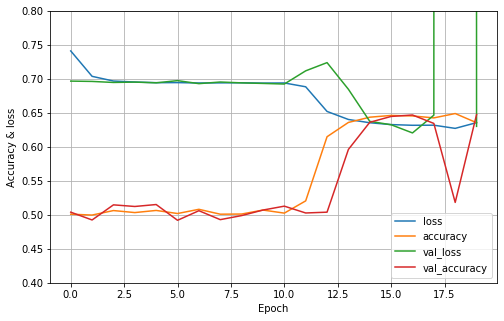

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy & loss')
plt.gca().set_ylim(0.4, 0.8)
plt.show()

In [29]:
# Évaluer la performance sur l'ensemble de test
loss, accuracy = model_cnn_bin.evaluate(X_test, y_test)

# Affichez les résultats
print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")

131/131 [==============================] - 4s 20ms/step - loss: 0.6302 - accuracy: 0.6353
Loss on test set: 0.6301835179328918
Accuracy on test set: 0.6353419423103333
